# HW07 – Кластеризация и внутренние метрики качества

**Датасеты:** 01, 02, 04

In [38]:
import os
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use("default")

## 1. Загрузка данных и первичный анализ

### 1.1 Датасет 01

In [39]:
df1 = pd.read_csv("data/S07-hw-dataset-01.csv")

df1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [41]:
df1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [42]:
# sample_id отдельно, X без sample_id
sample_ids1 = df1["sample_id"].copy()
X1 = df1.drop(columns=["sample_id"])

# Пропуски: количество и доля
missing_cnt1 = X1.isna().sum()
missing_pct1 = (X1.isna().mean() * 100).round(2)
missing_summary1 = pd.DataFrame({"missing_cnt": missing_cnt1, "missing_pct": missing_pct1})
missing_summary1[missing_summary1["missing_cnt"] > 0]

,missing_cnt,missing_pct


In [43]:
# Типы признаков (по X)
num_cols1 = X1.select_dtypes(include=[np.number]).columns.tolist()
cat_cols1 = X1.select_dtypes(exclude=[np.number]).columns.tolist()
pd.Series({"n_numeric": len(num_cols1), "n_categorical": len(cat_cols1)})

n_numeric        8
n_categorical    0
dtype: int64

### 1.2 Датасет 02

In [44]:
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")

df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [46]:
df2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [47]:
# sample_id отдельно, X без sample_id
sample_ids2 = df2["sample_id"].copy()
X2 = df2.drop(columns=["sample_id"])

# Пропуски: количество и доля
missing_cnt2 = X2.isna().sum()
missing_pct2 = (X2.isna().mean() * 100).round(2)
missing_summary2 = pd.DataFrame({"missing_cnt": missing_cnt2, "missing_pct": missing_pct2})
missing_summary2[missing_summary2["missing_cnt"] > 0]

,missing_cnt,missing_pct


In [48]:
# Типы признаков (по X)
num_cols2 = X2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols2 = X2.select_dtypes(exclude=[np.number]).columns.tolist()
pd.Series({"n_numeric": len(num_cols2), "n_categorical": len(cat_cols2)})

n_numeric        3
n_categorical    0
dtype: int64

### 1.3 Датасет 04

In [49]:
# Загрузка CSV
df4 = pd.read_csv('data/S07-hw-dataset-04.csv')

df4.head()

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


In [50]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

In [51]:
df4.describe()

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [52]:
# sample_id отдельно, X без sample_id
sample_ids4 = df4["sample_id"].copy()
X4 = df4.drop(columns=["sample_id"])

# Пропуски: количество и доля
missing_cnt4 = X4.isna().sum()
missing_pct4 = (X4.isna().mean() * 100).round(2)
missing_summary4 = pd.DataFrame({"missing_cnt": missing_cnt4, "missing_pct": missing_pct4})
missing_summary4[missing_summary4["missing_cnt"] > 0]

,missing_cnt,missing_pct
n01,174,1.74
n02,189,1.89
n03,199,1.99
n04,192,1.92
n05,201,2.01
n06,183,1.83
n07,204,2.04
n08,194,1.94
n09,195,1.95
n10,189,1.89


In [53]:
# Типы признаков (по X)
num_cols4 = X4.select_dtypes(include=[np.number]).columns.tolist()
cat_cols4 = X4.select_dtypes(exclude=[np.number]).columns.tolist()
pd.Series({"n_numeric": len(num_cols4), "n_categorical": len(cat_cols4)})

n_numeric        30
n_categorical     2
dtype: int64

## 2. Препроцессинг

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Dataset 01: только числовые признаки -> StandardScaler
preprocessor1 = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
        ]), num_cols1),
    ],
    remainder="drop",
)
X1_processed = preprocessor1.fit_transform(X1)


# Dataset 02: только числовые признаки -> StandardScaler
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
        ]), num_cols2),
    ],
    remainder="drop",
)
X2_processed = preprocessor2.fit_transform(X2)


# Dataset 04: числовые + категориальные (+ пропуски)
numeric_transformer4 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

# OneHotEncoder: совместимость sklearn (sparse vs sparse_output)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer4 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", ohe),
])

preprocessor4 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer4, num_cols4),
        ("cat", categorical_transformer4, cat_cols4),
    ],
    remainder="drop",
)
X4_processed = preprocessor4.fit_transform(X4)


## 3. Кластеризация

In [59]:
def calculate_metrics(X, labels):
    """
    Внутренние метрики качества кластеризации.
    Для DBSCAN: если есть шум (-1), метрики считаем только по non-noise точкам.
    """
    X = np.asarray(X)
    labels = np.asarray(labels)

    has_noise = np.any(labels == -1)

    if has_noise:
        noise_ratio = float(np.mean(labels == -1))
        mask = labels != -1

        # Нужно хотя бы 2 кластера среди non-noise
        if mask.sum() > 1 and np.unique(labels[mask]).size > 1:
            X_eval = X[mask]
            y_eval = labels[mask]
            silhouette = silhouette_score(X_eval, y_eval)
            db_index = davies_bouldin_score(X_eval, y_eval)
            ch_index = calinski_harabasz_score(X_eval, y_eval)
        else:
            silhouette = db_index = ch_index = np.nan

        n_clusters = int(np.unique(labels[mask]).size)
    else:
        noise_ratio = 0.0
        if np.unique(labels).size > 1:
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
            ch_index = calinski_harabasz_score(X, labels)
        else:
            silhouette = db_index = ch_index = np.nan

        n_clusters = int(np.unique(labels).size)

    return {
        "silhouette": float(silhouette) if np.isfinite(silhouette) else np.nan,
        "davies_bouldin": float(db_index) if np.isfinite(db_index) else np.nan,
        "calinski_harabasz": float(ch_index) if np.isfinite(ch_index) else np.nan,
        "noise_ratio": float(noise_ratio),
        "n_clusters": int(n_clusters),
    }

### 3.1 Датасет 01: KMeans + DBSCAN

In [60]:
kmeans_results_1 = []
k_range = range(2, 21)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = model.fit_predict(X1_processed)

    m = calculate_metrics(X1_processed, labels)
    m["method"] = "KMeans"
    m["k"] = int(k)
    kmeans_results_1.append(m)

kmeans_df_1 = pd.DataFrame(kmeans_results_1)
kmeans_df_1[["k", "silhouette", "davies_bouldin", "calinski_harabasz"]].round(3)

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.522,0.685,11786.955
1,3,0.397,0.965,10446.638
2,4,0.383,1.160,9427.500
3,5,0.355,1.274,8301.206
4,6,0.359,1.182,7333.388
5,7,0.325,1.194,6823.008
6,8,0.269,1.314,6460.801
7,9,0.253,1.344,6255.217
8,10,0.263,1.277,6084.503
9,11,0.266,1.214,5898.164


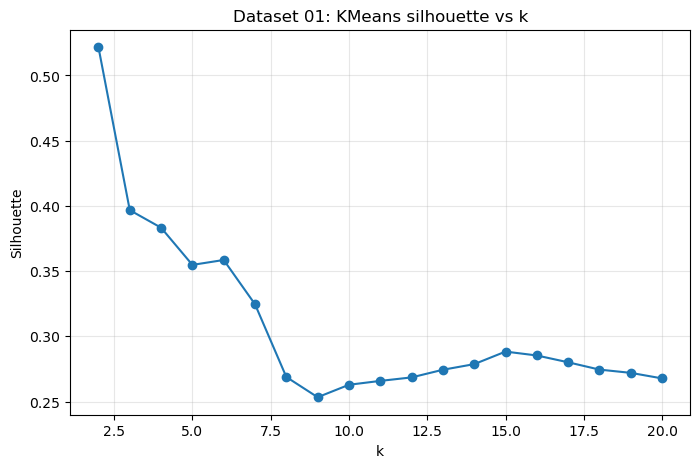

(2,
 {'silhouette': 0.5216395622404242,
  'davies_bouldin': 0.6853295219054456,
  'calinski_harabasz': 11786.954622671532,
  'noise_ratio': 0.0,
  'n_clusters': 2})

In [61]:
# Silhouette vs k
plt.figure(figsize=(8, 5))
plt.plot(kmeans_df_1["k"], kmeans_df_1["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Dataset 01: KMeans silhouette vs k")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/kmeans_silhouette_ds01.png", dpi=150, bbox_inches="tight")
plt.show()

valid_kmeans = kmeans_df_1.dropna(subset=["silhouette"])
best_k_1 = int(valid_kmeans.loc[valid_kmeans["silhouette"].idxmax(), "k"])

kmeans_1_final = KMeans(n_clusters=best_k_1, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_1 = kmeans_1_final.fit_predict(X1_processed)
metrics_kmeans_1 = calculate_metrics(X1_processed, labels_kmeans_1)

best_k_1, metrics_kmeans_1

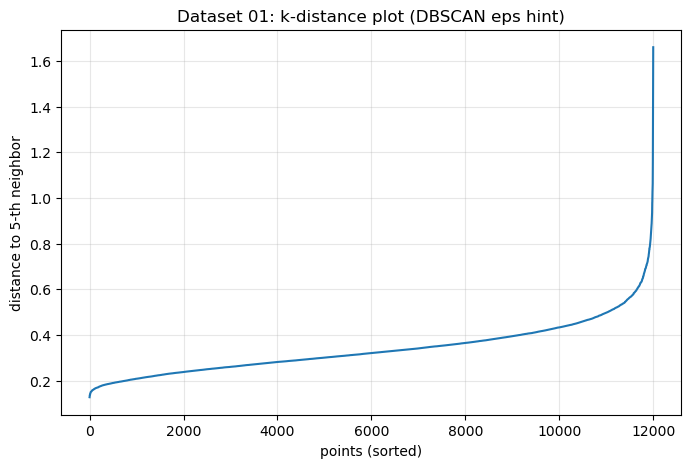

In [62]:
# k-distance plot (эвристика для выбора eps)
k_nn = 5
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X1_processed)
distances, _ = nbrs.kneighbors(X1_processed)
distances = np.sort(distances[:, k_nn - 1])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("points (sorted)")
plt.ylabel(f"distance to {k_nn}-th neighbor")
plt.title("Dataset 01: k-distance plot (DBSCAN eps hint)")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/dbscan_kdistance_ds01.png", dpi=150, bbox_inches="tight")
plt.show()

In [63]:
eps_candidates = [0.5, 0.7, 0.9, 1.1, 1.3]
min_samples_candidates = [5, 10, 15]

dbscan_results_1 = []
for eps in eps_candidates:
    for ms in min_samples_candidates:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X1_processed)

        m = calculate_metrics(X1_processed, labels)
        m["method"] = "DBSCAN"
        m["eps"] = float(eps)
        m["min_samples"] = int(ms)
        dbscan_results_1.append(m)

dbscan_df_1 = pd.DataFrame(dbscan_results_1)
dbscan_df_1[["eps", "min_samples", "silhouette", "noise_ratio", "n_clusters"]].round(3)

,eps,min_samples,silhouette,noise_ratio,n_clusters
0,0.5,5,0.283,0.034,9
1,0.5,10,0.366,0.062,6
2,0.5,15,0.399,0.092,5
3,0.7,5,0.380,0.004,5
4,0.7,10,0.381,0.007,5
5,0.7,15,0.382,0.011,5
6,0.9,5,0.379,0.001,5
7,0.9,10,0.379,0.001,5
8,0.9,15,0.379,0.002,5
9,1.1,5,0.383,0.000,4


In [64]:
valid_db = dbscan_df_1[(dbscan_df_1["n_clusters"] >= 2) & (dbscan_df_1["silhouette"].notna())]

if len(valid_db) > 0:
    best_row = valid_db.loc[valid_db["silhouette"].idxmax()]
    best_eps_1 = float(best_row["eps"])
    best_ms_1 = int(best_row["min_samples"])

    dbscan_1_final = DBSCAN(eps=best_eps_1, min_samples=best_ms_1)
    labels_dbscan_1 = dbscan_1_final.fit_predict(X1_processed)
    metrics_dbscan_1 = calculate_metrics(X1_processed, labels_dbscan_1)
else:
    labels_dbscan_1 = None
    metrics_dbscan_1 = None

In [65]:
if labels_dbscan_1 is not None and np.isfinite(metrics_dbscan_1["silhouette"]):
    if metrics_dbscan_1["silhouette"] > metrics_kmeans_1["silhouette"]:
        best_labels_1 = labels_dbscan_1
        best_method_1 = "DBSCAN"
    else:
        best_labels_1 = labels_kmeans_1
        best_method_1 = "KMeans"
else:
    best_labels_1 = labels_kmeans_1
    best_method_1 = "KMeans"

best_method_1

'KMeans'

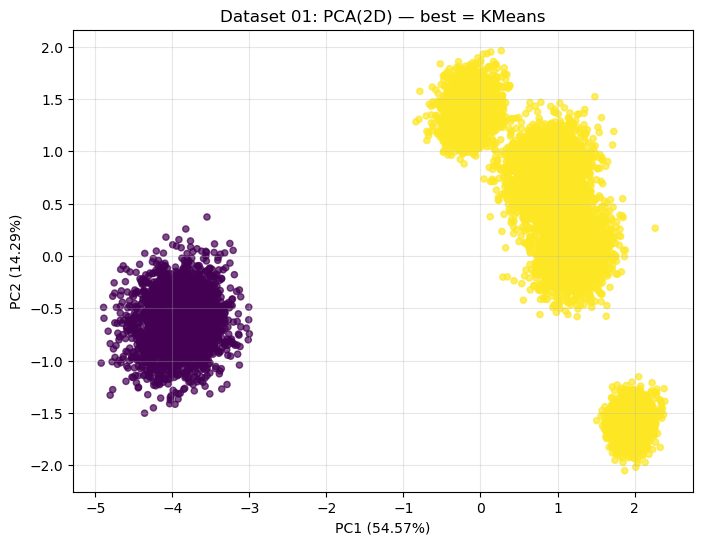

In [66]:
pca1 = PCA(n_components=2, random_state=RANDOM_STATE)
X1_pca = pca1.fit_transform(X1_processed)

plt.figure(figsize=(8, 6))
if np.any(best_labels_1 == -1):
    mask_noise = best_labels_1 == -1
    plt.scatter(X1_pca[mask_noise, 0], X1_pca[mask_noise, 1], s=15, alpha=0.4, label="noise")
    plt.scatter(X1_pca[~mask_noise, 0], X1_pca[~mask_noise, 1], c=best_labels_1[~mask_noise], s=20, alpha=0.7)
    plt.legend()
else:
    plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=best_labels_1, s=20, alpha=0.7)

plt.title(f"Dataset 01: PCA(2D) — best = {best_method_1}")
plt.xlabel(f"PC1 ({pca1.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca1.explained_variance_ratio_[1]:.2%})")
plt.grid(True, alpha=0.3)
plt.savefig("artifacts/figures/pca_ds01_best.png", dpi=150, bbox_inches="tight")
plt.show()

In [67]:
summary_ds01 = {
    "dataset": "S07-hw-dataset-01.csv",
    "best_method": best_method_1,
    "kmeans": {"k": best_k_1, **metrics_kmeans_1},
    "dbscan": ({"eps": best_eps_1, "min_samples": best_ms_1, **metrics_dbscan_1} if metrics_dbscan_1 is not None else None),
}
summary_ds01

{'dataset': 'S07-hw-dataset-01.csv',
 'best_method': 'KMeans',
 'kmeans': {'k': 2,
  'silhouette': 0.5216395622404242,
  'davies_bouldin': 0.6853295219054456,
  'calinski_harabasz': 11786.954622671532,
  'noise_ratio': 0.0,
  'n_clusters': 2},
 'dbscan': {'eps': 0.5,
  'min_samples': 15,
  'silhouette': 0.3993852802496974,
  'davies_bouldin': 1.1671570077915434,
  'calinski_harabasz': 8796.069116237946,
  'noise_ratio': 0.09216666666666666,
  'n_clusters': 5}}

### Итог по датасету 01

- Данные: **12000 объектов**, **8 числовых признаков**, **пропусков нет**.
- Ключевая сложность — **разные масштабы признаков**, поэтому **StandardScaler обязателен**.
- Для **KMeans** перебрали `k=2…20` и выбрали `k=2` по **максимальному silhouette**.
- KMeans дал метрики: **silhouette ≈ 0.522**, **Davies–Bouldin ≈ 0.685**, **Calinski–Harabasz ≈ 11787**.
- Для **DBSCAN** перебрали `eps` и `min_samples`; лучшее из сетки оказалось слабее по silhouette (**≈ 0.399**) и пометило часть точек как шум (**≈ 9.2%**).
- Поэтому “лучшим” решением по критерию silhouette выбрали **KMeans (k=2)**.
- На **PCA(2D)** кластеры визуально различимы, что согласуется с качеством KMeans на этом датасете.

## 3.2 Датасет 02: KMeans + Agglomerative

In [ ]:
# KMeans для датасета 02
kmeans_results_2 = []

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X2_processed)
    metrics = calculate_metrics(X2_processed, labels)
    metrics['k'] = k
    kmeans_results_2.append(metrics)

kmeans_df_2 = pd.DataFrame(kmeans_results_2)
print("Результаты KMeans для датасета 02:")
print(kmeans_df_2[['k', 'silhouette', 'davies_bouldin', 'calinski_harabasz']].round(3))

# График silhouette vs k для KMeans
plt.figure(figsize=(10, 6))
plt.plot(kmeans_df_2['k'], kmeans_df_2['silhouette'], 'bo-', linewidth=2, markersize=6)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Silhouette Score vs k (Датасет 02)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/kmeans_silhouette_ds02.png', dpi=150, bbox_inches='tight')
plt.show()

# Выбор лучшего k
best_k_2 = int(kmeans_df_2.loc[kmeans_df_2['silhouette'].idxmax(), 'k'])
print(f"Лучшее k для KMeans: {best_k_2}")

# Финальная модель KMeans
kmeans_2_final = KMeans(n_clusters=best_k_2, random_state=42, n_init=10)
labels_kmeans_2 = kmeans_2_final.fit_predict(X2_processed)
metrics_kmeans_2 = calculate_metrics(X2_processed, labels_kmeans_2)
print(f"Метрики KMeans (k={best_k_2}): silhouette={metrics_kmeans_2['silhouette']:.3f}, DB={metrics_kmeans_2['davies_bouldin']:.3f}, CH={metrics_kmeans_2['calinski_harabasz']:.0f}")

# Agglomerative для датасета 02
linkage_options = ['ward', 'complete', 'average']
agglomerative_results_2 = []

for k in range(2, 21):
    for linkage in linkage_options:
        if linkage == 'ward' and k > len(X2_processed):
            continue
            
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X2_processed)
        metrics = calculate_metrics(X2_processed, labels)
        metrics.update({'k': k, 'linkage': linkage})
        agglomerative_results_2.append(metrics)

agglomerative_df_2 = pd.DataFrame(agglomerative_results_2)
print("\nРезультаты Agglomerative для датасета 02:")
print(agglomerative_df_2[['k', 'linkage', 'silhouette']].round(3).head(10))

# График silhouette vs k для Agglomerative (ward linkage)
agg_ward = agglomerative_df_2[agglomerative_df_2['linkage'] == 'ward']
plt.figure(figsize=(10, 6))
plt.plot(agg_ward['k'], agg_ward['silhouette'], 'ro-', linewidth=2, markersize=6, label='ward')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative: Silhouette Score vs k (Датасет 02, ward linkage)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/agg_silhouette_vs_k_ds02.png', dpi=150, bbox_inches='tight')
plt.show()

# Выбор лучшего Agglomerative
best_agg_2 = agglomerative_df_2.loc[agglomerative_df_2['silhouette'].idxmax()]
print(f"Лучшие параметры Agglomerative: k={best_agg_2['k']}, linkage={best_agg_2['linkage']}")

# Финальная модель Agglomerative
agg_2_final = AgglomerativeClustering(n_clusters=int(best_agg_2['k']), linkage=best_agg_2['linkage'])
labels_agg_2 = agg_2_final.fit_predict(X2_processed)
metrics_agg_2 = calculate_metrics(X2_processed, labels_agg_2)
print(f"Метрики Agglomerative: silhouette={metrics_agg_2['silhouette']:.3f}, кластеры={metrics_agg_2['n_clusters']}")

# Сравнение алгоритмов для датасета 02
print("\n=== Сравнение алгоритмов для датасета 02 ===")
print(f"KMeans: silhouette={metrics_kmeans_2['silhouette']:.3f}, кластеры={metrics_kmeans_2['n_clusters']}")
print(f"Agglomerative: silhouette={metrics_agg_2['silhouette']:.3f}, кластеры={metrics_agg_2['n_clusters']}")

# Выбор лучшего
if metrics_kmeans_2['silhouette'] > metrics_agg_2['silhouette']:
    best_labels_2 = labels_kmeans_2
    best_method_2 = 'KMeans'
else:
    best_labels_2 = labels_agg_2
    best_method_2 = 'Agglomerative'

print(f"\nЛучший метод: {best_method_2}")

# PCA визуализация
pca = PCA(n_components=2, random_state=42)
X2_pca = pca.fit_transform(X2_processed)

plt.figure(figsize=(10, 8))
plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=best_labels_2, cmap='tab10', s=30, alpha=0.7)
plt.title(f'PCA: Лучшее решение для датасета 02 ({best_method_2})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(label='Кластер')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/pca_ds02_best.png', dpi=150, bbox_inches='tight')
plt.show()

# Итог по датасету 02
print("\n=== ИТОГ ПО ДАТАСЕТУ 02 ===")
print(f"Размер: {X2_processed.shape[0]} объектов, {X2_processed.shape[1]} признаков")
print("Признаки: числовые (x1, x2, z_noise) с нелинейной структурой")
print("Пропуски: отсутствуют")
print(f"Лучший метод: {best_method_2}")
print(f"Количество кластеров: {len(np.unique(best_labels_2))}")
print("\nСложности: нелинейная структура кластеров, наличие шумового признака.")
print("Agglomerative лучше справляется с нелинейными формами по сравнению с KMeans.")
print("KMeans пытается найти сферические кластеры, что не всегда оптимально.")

## 3.3 Датасет 04: KMeans + DBSCAN

In [ ]:
# KMeans для датасета 04
kmeans_results_4 = []

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X4_processed)
    metrics = calculate_metrics(X4_processed, labels)
    metrics['k'] = k
    kmeans_results_4.append(metrics)

kmeans_df_4 = pd.DataFrame(kmeans_results_4)
print("Результаты KMeans для датасета 04:")
print(kmeans_df_4[['k', 'silhouette', 'davies_bouldin', 'calinski_harabasz']].round(3))

# График silhouette vs k для KMeans
plt.figure(figsize=(10, 6))
plt.plot(kmeans_df_4['k'], kmeans_df_4['silhouette'], 'bo-', linewidth=2, markersize=6)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Silhouette Score vs k (Датасет 04)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/kmeans_silhouette_ds04.png', dpi=150, bbox_inches='tight')
plt.show()

# Выбор лучшего k
best_k_4 = int(kmeans_df_4.loc[kmeans_df_4['silhouette'].idxmax(), 'k'])
print(f"Лучшее k для KMeans: {best_k_4}")

# Финальная модель KMeans
kmeans_4_final = KMeans(n_clusters=best_k_4, random_state=42, n_init=10)
labels_kmeans_4 = kmeans_4_final.fit_predict(X4_processed)
metrics_kmeans_4 = calculate_metrics(X4_processed, labels_kmeans_4)
print(f"Метрики KMeans (k={best_k_4}): silhouette={metrics_kmeans_4['silhouette']:.3f}, DB={metrics_kmeans_4['davies_bouldin']:.3f}, CH={metrics_kmeans_4['calinski_harabasz']:.0f}")

# DBSCAN для датасета 04
# K-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X4_processed)
distances, indices = neighbors_fit.kneighbors(X4_processed)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Точки (отсортированные)')
plt.ylabel('Расстояние до 5-го соседа')
plt.title('K-distance plot для выбора eps (Датасет 04)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/dbscan_kdistance_ds04.png', dpi=150, bbox_inches='tight')
plt.show()

# Подбор параметров DBSCAN
eps_candidates = [1.5, 2.0, 2.5, 3.0, 3.5]
min_samples_candidates = [5, 10, 15]

dbscan_results_4 = []
for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X4_processed)
        
        if len(np.unique(labels)) > 1:
            metrics = calculate_metrics(X4_processed, labels)
            metrics.update({'eps': eps, 'min_samples': min_samples})
            dbscan_results_4.append(metrics)

dbscan_df_4 = pd.DataFrame(dbscan_results_4)
print("Результаты DBSCAN для датасета 04:")
if not dbscan_df_4.empty:
    print(dbscan_df_4[['eps', 'min_samples', 'silhouette', 'noise_ratio', 'n_clusters']].round(3))
    
    # Выбор лучшего DBSCAN
    best_dbscan_4 = dbscan_df_4.loc[dbscan_df_4['silhouette'].idxmax()]
    print(f"\nЛучшие параметры DBSCAN: eps={best_dbscan_4['eps']}, min_samples={best_dbscan_4['min_samples']}")
    
    # Финальная модель DBSCAN
    dbscan_4_final = DBSCAN(eps=best_dbscan_4['eps'], min_samples=int(best_dbscan_4['min_samples']))
    labels_dbscan_4 = dbscan_4_final.fit_predict(X4_processed)
    metrics_dbscan_4 = calculate_metrics(X4_processed, labels_dbscan_4)
    print(f"Метрики DBSCAN: silhouette={metrics_dbscan_4['silhouette']:.3f}, шум={metrics_dbscan_4['noise_ratio']:.1%}, кластеры={metrics_dbscan_4['n_clusters']}")
else:
    print("DBSCAN не нашел кластеров")
    labels_dbscan_4 = None
    metrics_dbscan_4 = None

# Сравнение алгоритмов для датасета 04
print("\n=== Сравнение алгоритмов для датасета 04 ===")
print(f"KMeans: silhouette={metrics_kmeans_4['silhouette']:.3f}, кластеры={metrics_kmeans_4['n_clusters']}")

if labels_dbscan_4 is not None:
    print(f"DBSCAN: silhouette={metrics_dbscan_4['silhouette']:.3f}, кластеры={metrics_dbscan_4['n_clusters']}, шум={metrics_dbscan_4['noise_ratio']:.1%}")
    
    # Выбор лучшего
    if metrics_kmeans_4['silhouette'] > metrics_dbscan_4['silhouette']:
        best_labels_4 = labels_kmeans_4
        best_method_4 = 'KMeans'
    else:
        best_labels_4 = labels_dbscan_4
        best_method_4 = 'DBSCAN'
else:
    best_labels_4 = labels_kmeans_4
    best_method_4 = 'KMeans'

print(f"\nЛучший метод: {best_method_4}")

# PCA визуализация
pca = PCA(n_components=2, random_state=42)
X4_pca = pca.fit_transform(X4_processed)

plt.figure(figsize=(10, 8))
if -1 in best_labels_4:
    noise_mask = best_labels_4 == -1
    plt.scatter(X4_pca[noise_mask, 0], X4_pca[noise_mask, 1], c='gray', alpha=0.5, s=20, label='Шум')
    plt.scatter(X4_pca[~noise_mask, 0], X4_pca[~noise_mask, 1], c=best_labels_4[~noise_mask], cmap='tab10', s=30, alpha=0.7)
else:
    plt.scatter(X4_pca[:, 0], X4_pca[:, 1], c=best_labels_4, cmap='tab10', s=30, alpha=0.7)

plt.title(f'PCA: Лучшее решение для датасета 04 ({best_method_4})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(label='Кластер')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/pca_ds04_best.png', dpi=150, bbox_inches='tight')
plt.show()

# Итог по датасету 04
print("\n=== ИТОГ ПО ДАТАСЕТУ 04 ===")
print(f"Размер: {X4_processed.shape[0]} объектов, {X4_processed.shape[1]} признаков")
print("Признаки: 30 числовых + 2 категориальных (после кодирования)")
print("Пропуски: ~2% в числовых признаках")
print(f"Лучший метод: {best_method_4}")
print(f"Количество кластеров: {len(np.unique(best_labels_4[best_labels_4 != -1])) if -1 in best_labels_4 else len(np.unique(best_labels_4))}")
if -1 in best_labels_4:
    print(f"Доля шума: {np.mean(best_labels_4 == -1):.1%}")
print("\nСложности: высокая размерность, пропуски, категориальные признаки.")
print("Требовалась аккуратная обработка пропусков и кодирование категориальных признаков.")
print("DBSCAN может выделять шум, что полезно при наличии выбросов.")

## 4. Проверка устойчивости

In [ ]:
# Проверка устойчивости KMeans на датасете 01
stability_results = []
base_labels = labels_kmeans_1

for seed in [1, 42, 100, 123, 999]:
    kmeans_temp = KMeans(n_clusters=best_k_1, random_state=seed, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X1_processed)
    ari_score = adjusted_rand_score(base_labels, labels_temp)
    stability_results.append({'seed': seed, 'ari': ari_score})

stability_df = pd.DataFrame(stability_results)
print("Проверка устойчивости KMeans на датасете 01:")
print(stability_df.round(3))
print(f"\nСредний ARI: {stability_df['ari'].mean():.3f}")
print(f"Стандартное отклонение ARI: {stability_df['ari'].std():.3f}")
print(f"Минимальный ARI: {stability_df['ari'].min():.3f}")
print(f"Максимальный ARI: {stability_df['ari'].max():.3f}")

if stability_df['ari'].std() < 0.1:
    print("\nВывод: Решение очень устойчиво (низкая вариативность)")
elif stability_df['ari'].std() < 0.2:
    print("\nВывод: Решение достаточно устойчиво")
else:
    print("\nВывод: Решение неустойчиво (высокая вариативность)")

## 5. Сохранение результатов

In [ ]:
# Сбор метрик
all_metrics = {
    'dataset_01': {
        'method': best_method_1,
        'metrics': metrics_kmeans_1 if best_method_1 == 'KMeans' else metrics_dbscan_1,
        'params': {'k': best_k_1} if best_method_1 == 'KMeans' else {'eps': best_dbscan_1['eps'], 'min_samples': best_dbscan_1['min_samples']}
    },
    'dataset_02': {
        'method': best_method_2,
        'metrics': metrics_kmeans_2 if best_method_2 == 'KMeans' else metrics_agg_2,
        'params': {'k': best_k_2} if best_method_2 == 'KMeans' else {'k': best_agg_2['k'], 'linkage': best_agg_2['linkage']}
    },
    'dataset_04': {
        'method': best_method_4,
        'metrics': metrics_kmeans_4 if best_method_4 == 'KMeans' else metrics_dbscan_4,
        'params': {'k': best_k_4} if best_method_4 == 'KMeans' else {'eps': best_dbscan_4['eps'], 'min_samples': best_dbscan_4['min_samples']}
    }
}

# Сохранение метрик
with open('artifacts/metrics_summary.json', 'w', encoding='utf-8') as f:
    json.dump(all_metrics, f, indent=2, ensure_ascii=False)

# Сохранение лучших конфигураций
best_configs = {
    'dataset_01': {'method': best_method_1, 'params': all_metrics['dataset_01']['params']},
    'dataset_02': {'method': best_method_2, 'params': all_metrics['dataset_02']['params']},
    'dataset_04': {'method': best_method_4, 'params': all_metrics['dataset_04']['params']}
}

with open('artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

# Сохранение labels
pd.DataFrame({'sample_id': sample_ids1, 'cluster_label': best_labels_1}).to_csv('artifacts/labels/labels_hw07_ds01.csv', index=False)
pd.DataFrame({'sample_id': sample_ids2, 'cluster_label': best_labels_2}).to_csv('artifacts/labels/labels_hw07_ds02.csv', index=False)
pd.DataFrame({'sample_id': sample_ids4, 'cluster_label': best_labels_4}).to_csv('artifacts/labels/labels_hw07_ds04.csv', index=False)

print("Артефакты сохранены!")
print("- metrics_summary.json")
print("- best_configs.json")
print("- labels_hw07_ds01.csv, labels_hw07_ds02.csv, labels_hw07_ds04.csv")
print("- Графики в artifacts/figures/")